In [1]:
from statsmodels.stats.weightstats import ttest_ind
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybullet_envs
import scipy.stats as st
import seaborn as sns

from info import path_to, config
from file_system import FS

env_names = config.env_names
# env_names = ["LunarLanderContinuous-v2"]

settings = config.train_afrl.env_settings

sns.set_theme(style="whitegrid")

In [2]:
def confidence_interval(xs):
    return st.t.interval(0.95, len(xs)-1, loc=np.mean(xs), scale=st.sem(xs))

def mk_plot_epsilon_coefficient_1(env_name):
    plt.figure(figsize=(5.5, 5.5))
    
    if not FS.exists(path_to.experiment_csv_for(env_name)):
        print(f"no data found for: {env_name}")
        return
    
    ax = plt.subplot(1,1,1)
    afrl = pd.read_csv(path_to.experiment_csv_for(env_name)).rename(columns={'discounted_rewards': 'V'})
    vmax, vmin = settings[env_name]['max_score'], settings[env_name]['min_score']
    vmax = afrl.groupby('epsilon').V.mean().values[0]
    vrange = vmax - vmin
    afrl['opt'] = (afrl.V - vmin) / vrange
    afrl['eps'] = afrl.epsilon / vrange
    base_mean = 1
    af_means = afrl.groupby('eps').opt.mean()
    sd = afrl.groupby('eps').opt.std().values
    epsilon_low, epsilon_hgh = afrl.eps.min(), afrl.eps.max()
    epsilon = np.linspace(0, epsilon_hgh, 2)
    subopt = epsilon / (1 - config.gamma)
    plt.plot(epsilon, base_mean-subopt, color='orange', label='Perform. Bounds')
    af_means.plot(label='V^{PAC}(s_0)', marker='o', ax=ax, color='steelblue')
    plt.fill_between(af_means.index, af_means-sd, af_means+sd, alpha=0.2, color='steelblue')
    plt.hlines(base_mean, epsilon_low, epsilon_hgh, color='green', label='V^pi(s_0)')

    plt.plot([epsilon_low, epsilon_hgh], [0,0], color='red', label='V^{rand}(s_0)')

    plt.xlabel('Epsilon Coefficient')

    plt.ylim(-.1, 1.1)

    plt.legend(loc='lower left', fontsize="x-small")
    plt.title(env_name)
    
    print(plt.tight_layout())


def mk_plot_epsilon_coefficient_2(env_name):
    afrl = pd.read_csv(path_to.experiment_csv_for(env_name)).rename(columns={'discounted_rewards': 'V', 'Unnamed: 0': 'episode'})
    vmax, vmin = settings[env_name]['max_score'], settings[env_name]['min_score']
    vrange = vmax - vmin
    afrl['opt'] = (afrl.V - vmin) / vrange
    afrl['eps'] = afrl.epsilon / vrange

    f_means = afrl.groupby('eps').forecast.mean() + 1
    sd = afrl.groupby(['eps', 'episode']).forecast.mean().unstack().std(1)

    f_low, f_hgh = f_means + sd, f_means - sd
    f_means.plot(marker='o', label='V^F(s_0)', color='steelblue')
    plt.fill_between(f_means.index, np.where(f_low < 0, 0, f_low), f_hgh, alpha=0.2, color='steelblue')

    plt.xlabel('Epsilon Coefficient')

    plt.ylabel('Forecast')
    plt.title(env_name)
    plt.tight_layout()


def plot_3(env_name):
    plt.figure(figsize=(10,6))
    df = pd.read_csv(path_to.experiment_csv_for(env_name))
    df = df.set_index('ep_num')
    for i, col in enumerate(df.columns):
        ax = plt.subplot(2, 3, i+1)
        df[col].iloc[1:].rolling(10).mean().plot(ax=ax)
        plt.title(col)
    plt.tight_layout()

None
None
None
None


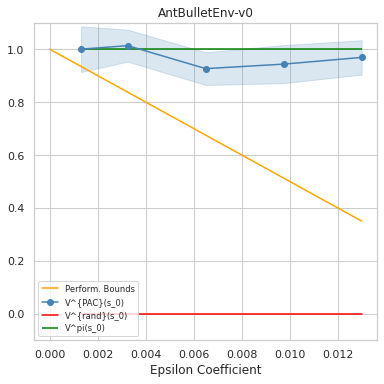

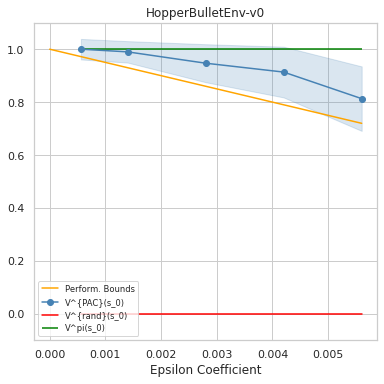

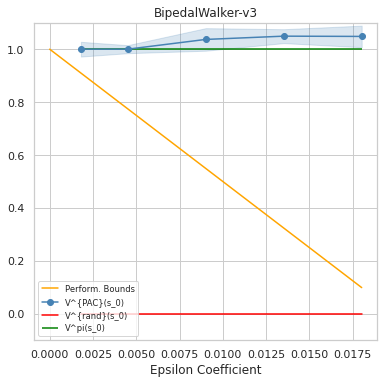

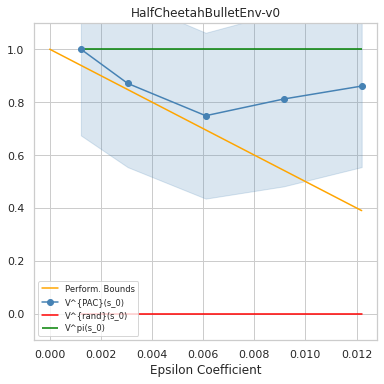

In [3]:
for each in env_names: mk_plot_epsilon_coefficient_1(each)

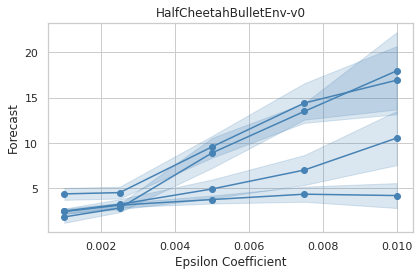

In [4]:
for each in env_names: mk_plot_epsilon_coefficient_2(each)

In [10]:
from IPython import display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

print(dir(display))
print(os.environ["DISPLAY"])
print([each for each in dir(display) if each[0] != '_'])
print(display.display)
print(display.env)
print(display.is_alive)
print(display.new_display_var)
print(display.pid)
print(display.start)
print(display.stop)



for index, env_name in enumerate(env_names):
    # 
    # get the image of the env
    # 
    env = config.get_env(env_name)
    # env = gym.wrappers.Monitor(env, '/tmp/video', video_callable=lambda x: True, force=True)
    
    env.render('rgb_array')
    env.reset()
    # env.step(env.action_space.sample())
    image = env.render('rgb_array')
    env.close()
    
    # 
    # trim them image
    # 
    plt.subplot(3, 2, index+1)
    diff = img.shape[1] - img.shape[0]
    trim = diff // 2
    img = img[:,trim:img.shape[1]-trim,:]
    
    # 
    # show it
    # 
    plt.imshow(img)
    # plt.frame(off)
    plt.xticks([])
    plt.yticks([])
    plt.title(env_name)

plt.tight_layout()

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_backend', '_bgcolor', '_color_depth', '_obj', '_size', '_visible', 'display', 'env', 'is_alive', 'new_display_var', 'pid', 'start', 'stop']
:3.0
['display', 'env', 'is_alive', 'new_display_var', 'pid', 'start', 'stop']
3
<bound method Display.env of <pyvirtualdisplay.display.Display object at 0x7f51130b8d30>>
<bound method Display.is_alive of <pyvirtualdisplay.display.Display object at 0x7f51130b8d30>>
:3
12685
<bound method Display.start of <pyvirtualdisplay.display.Display object at 0x7f51130b8d30>>
<bound method Display.stop of <pyvirtualdisplay.display.Display object at 0x7f51130b8d30>>


GLXInfoException: Could not determine GLX server version

In [23]:
! poetry add pyvirtualdisplay

The following packages are already present in the pyproject.toml and will be skipped:

  • pyvirtualdisplay

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [5]:
plot_3(env_name)

NameError: name 'env_name' is not defined